## 発現変動遺伝子解析 (DEseq2) の結果をMA plotとして可視化する (T>C read)
`DESeq2`で検出された発現変動遺伝子について解析。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# color-blind safe color scheme from https://personal.sron.nl/~pault/#fig:scheme_bright
blue, cyan, green, yellow = "#4477AA", "#66CCEE", "#228833", "#CCBB44"
red, purple, grey, black = "#EE6677", "#AA3377", "#BBBBBB", "#333333"

## 特定の遺伝子サブセットについて発現変動量が変化しているかどうか調べる。
小胞体ストレス時にポリソームフラクションに濃縮される遺伝子セットについて調べる。Total reads, T>C reads, Non-T>C reads　についてそれぞれプロット。

In [2]:
genes_polysome = pd.read_csv("../geneset/Baird_2014_UPR_translated_human.csv")
genes_polysome = list(genes_polysome["Gene name"])

def is_translated_by_polysome(df):
    if df["gene"] in genes_polysome:
        return 1
    else:
        return 0

# ERにターゲティングされる遺伝子セット
genes_ER = pd.read_csv("../geneset/Reid_2014_ER_targeted_human.csv")
genes_ER = list(genes_ER["Gene name"])

def is_targeted_ER(df):
    if df["gene"] in genes_ER:
        return 1
    else:
        return 0
    
# TPG処理時にATF4とCHOPの標的となる遺伝子セット
geneset_Han = pd.read_csv("../geneset/Han_2013_ATF4-CHOP_targeted_human.csv")
targets_ATF4 = list(geneset_Han[geneset_Han["Overlap"] == "ATF4_Only"]["Gene name"])
targets_CHOP = list(geneset_Han[geneset_Han["Overlap"] == "CHOP_Only"]["Gene name"])
targets_ATF4_and_CHOP = list(geneset_Han[geneset_Han["Overlap"] == "Common"]["Gene name"])

def is_ATF4_and_CHOP_target(df):

    if (df["gene"] in targets_ATF4):
        return "ATF4"
    elif (df["gene"] in targets_CHOP):
        return "CHOP"
    elif (df["gene"] in targets_ATF4_and_CHOP):
        return "ATF4 and CHOP"
    else: 
        return "ns"
    
def is_ATF4_and_CHOP_target(df):
    if df["gene"] in list(geneset_Han["Gene name"]):
        return 1
    else:
        return 0
    
# XBP1とATF6の標的遺伝子セット
geneset_Shoulders = pd.read_csv("../geneset/Shoulders_2013_XBP1-ATF6_targeted.csv")
targets_XBP1_and_ATF6 = list(geneset_Shoulders["Symbol"])
    
def is_XBP1_and_ATF6_target(df):
    if df["gene"] in targets_XBP1_and_ATF6:
        return 1
    else:
        return 0

In [3]:
# index から遺伝子名を取得
def get_gene_name(df):
    return df["index"].split("|")[0]

# eIF2 alpha 依存的な翻訳促進

In [4]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["polysome"] = df1.apply(is_translated_by_polysome, axis=1)
df2["polysome"] = df2.apply(is_translated_by_polysome, axis=1)
df3["polysome"] = df3.apply(is_translated_by_polysome, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (Polysome): 0.21884655762714633
WMW test (Polysome): 0.5986123726153126
WMW test (Polysome): 0.1921575105704858


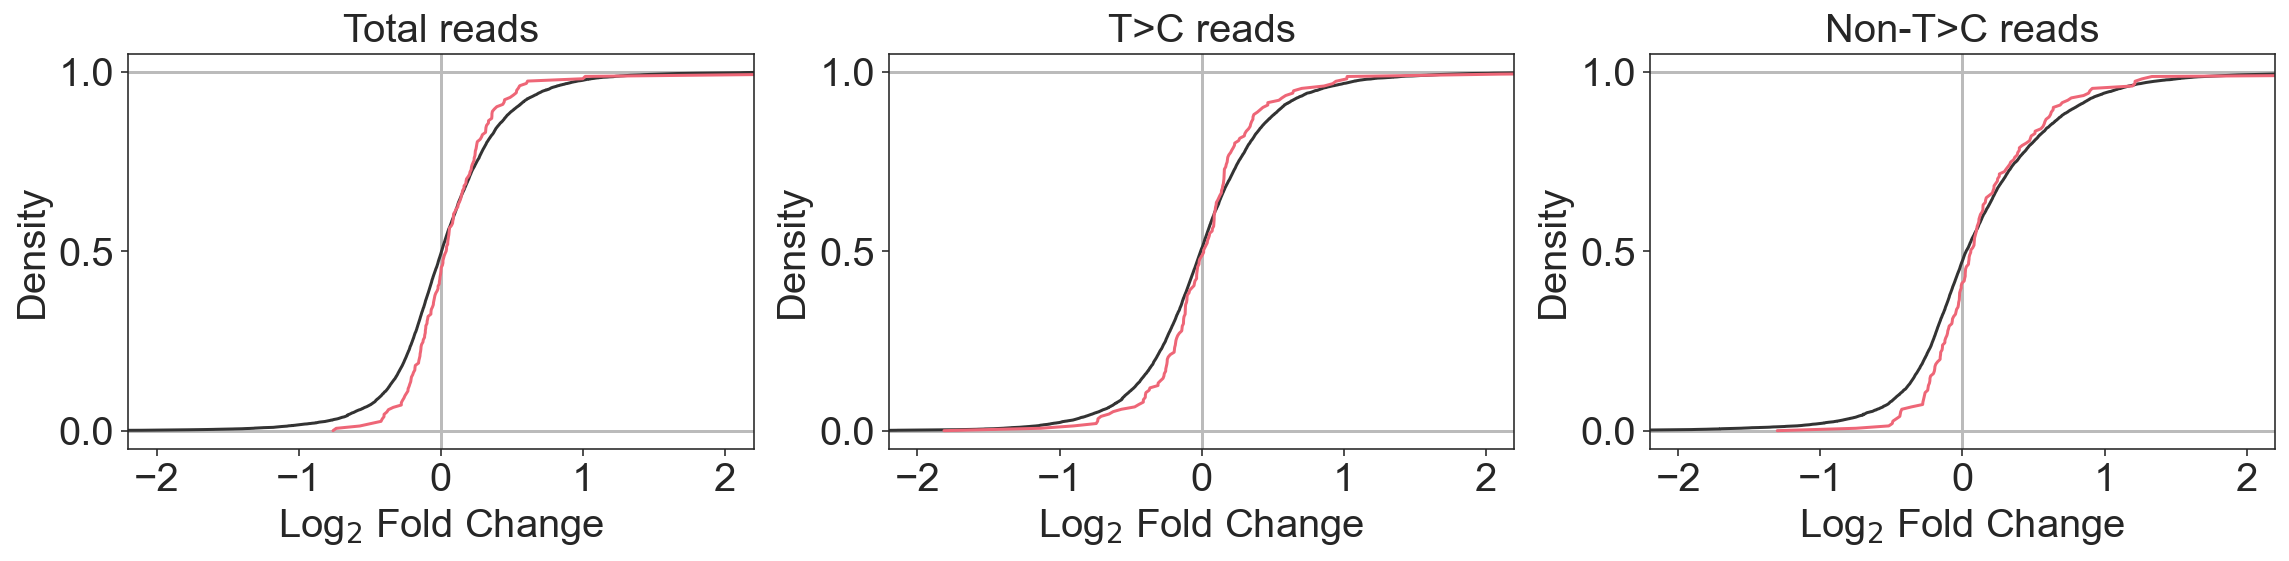

In [6]:
# subplot
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data3 = df[df["polysome"] == 1]["log2FC"]        # Preferential translation uopn eIF2a-P
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data3), 1 * np.arange(len(data3)) / (len(data3) - 1), color=red, label="Polysome")
    
    # Mann-Whitney U test
    MannResult_polysome = stats.mannwhitneyu(data1, data3, alternative="two-sided")
    print(f"WMW test (Polysome): {MannResult_polysome.pvalue}")

ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_eIF2a_RNA.pdf", bbox_inches="tight", transparent=True)

In [7]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["polysome"] = df1.apply(is_translated_by_polysome, axis=1)
df2["polysome"] = df2.apply(is_translated_by_polysome, axis=1)
df3["polysome"] = df3.apply(is_translated_by_polysome, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (Polysome): 2.4427132811788e-06
WMW test (Polysome): 0.06197772791755921
WMW test (Polysome): 0.00012867417388055176


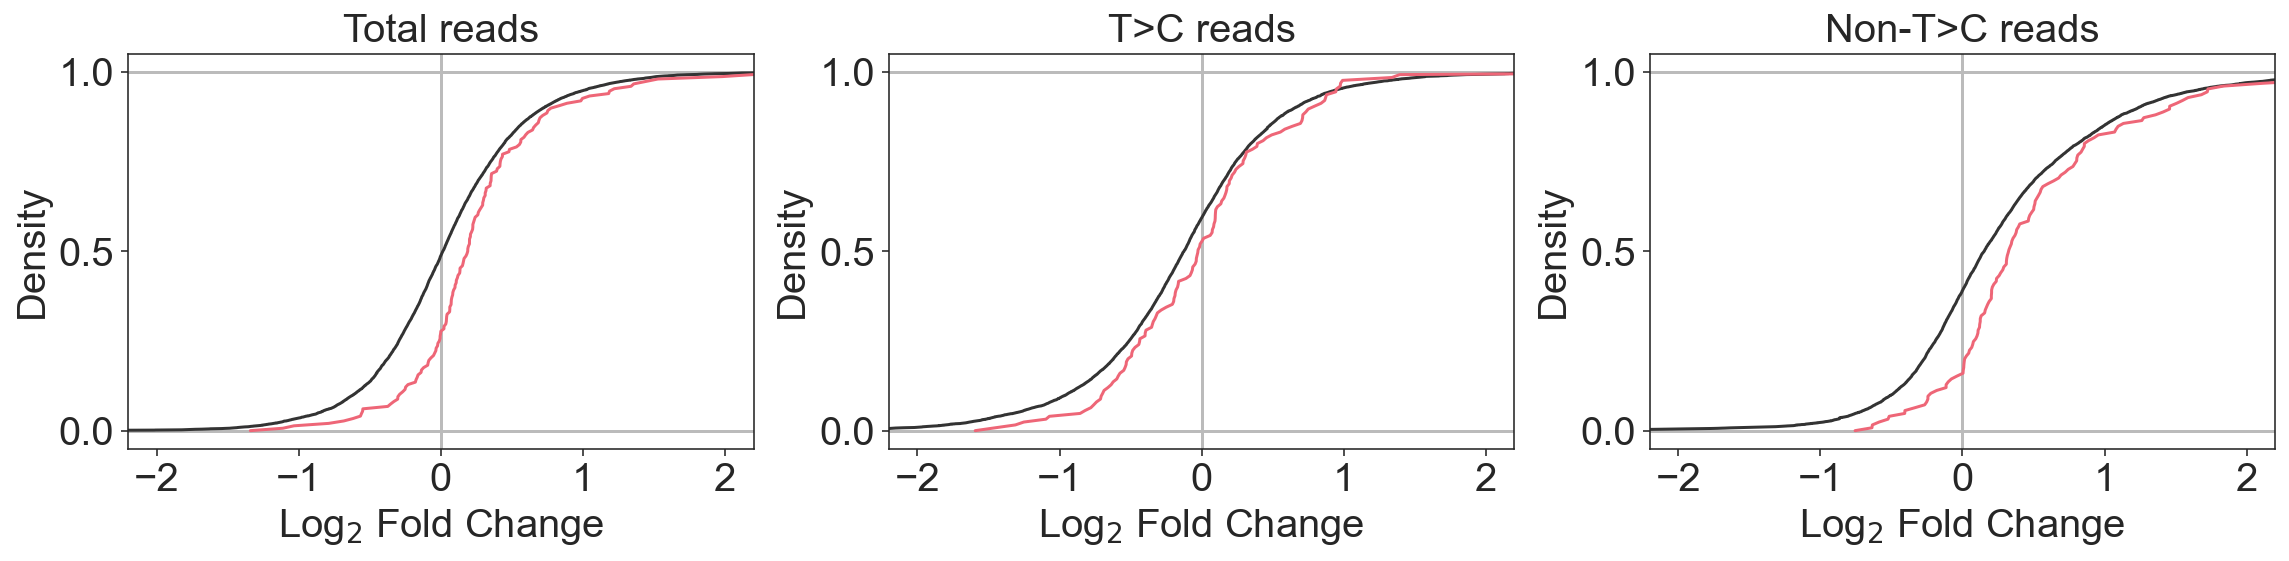

In [8]:
# subplot
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data3 = df[df["polysome"] == 1]["log2FC"]        # Preferential translation uopn eIF2a-P
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data3), 1 * np.arange(len(data3)) / (len(data3) - 1), color=red, label="Polysome")
    
    # Mann-Whitney U test
    MannResult_polysome = stats.mannwhitneyu(data1, data3, alternative="two-sided")
    print(f"WMW test (Polysome): {MannResult_polysome.pvalue}")

ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_eIF2a_P0.pdf", bbox_inches="tight", transparent=True)

In [9]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["polysome"] = df1.apply(is_translated_by_polysome, axis=1)
df2["polysome"] = df2.apply(is_translated_by_polysome, axis=1)
df3["polysome"] = df3.apply(is_translated_by_polysome, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (Polysome): 1.6314970501047495e-06
WMW test (Polysome): 0.020968620636803683
WMW test (Polysome): 3.493371119090142e-05


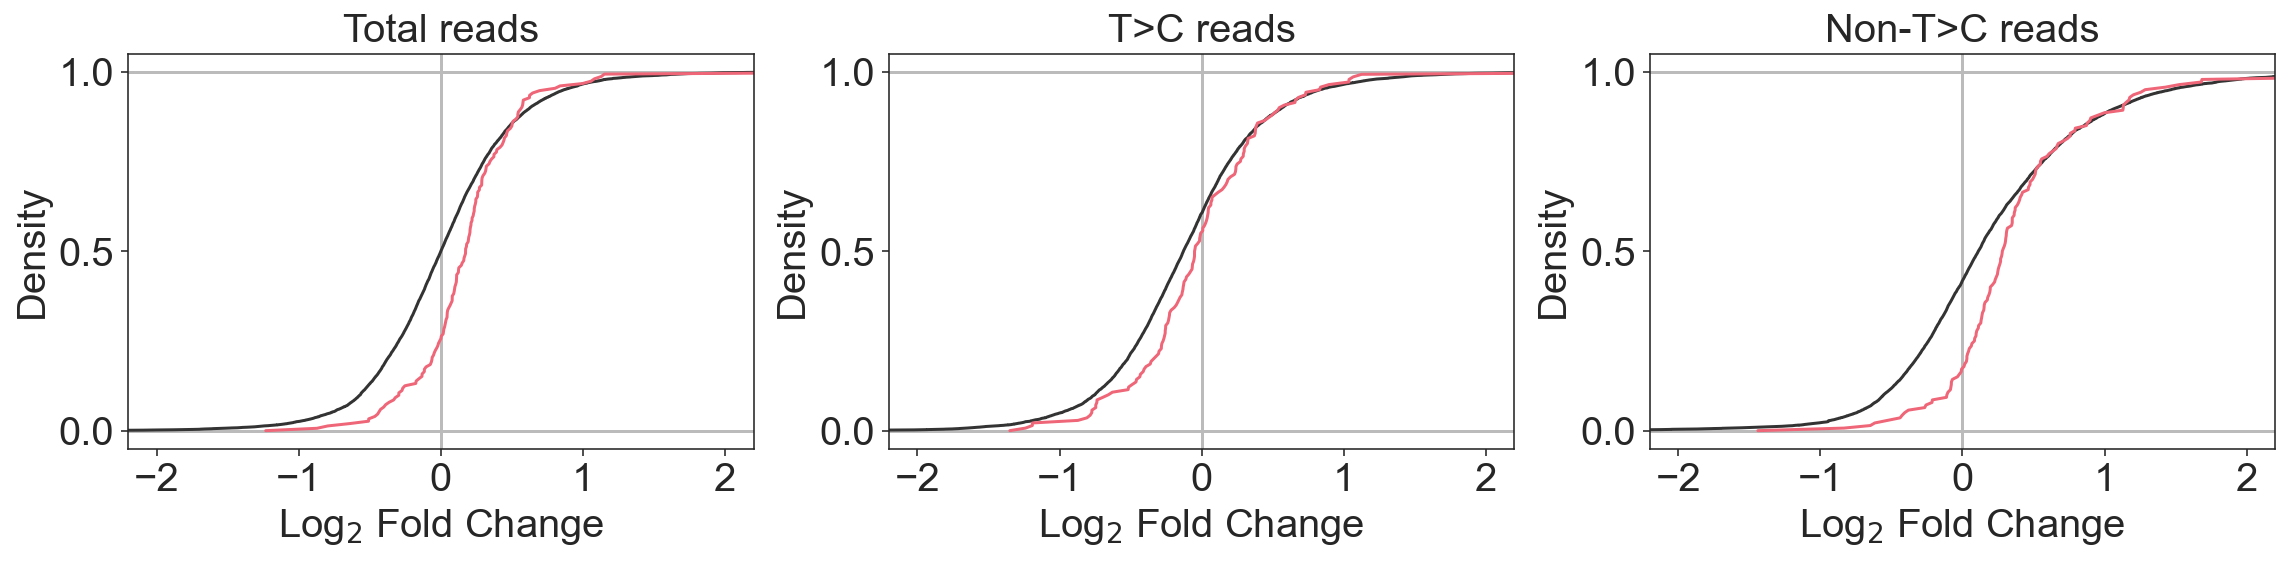

In [10]:
# subplot
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data3 = df[df["polysome"] == 1]["log2FC"]        # Preferential translation uopn eIF2a-P
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data3), 1 * np.arange(len(data3)) / (len(data3) - 1), color=red, label="Polysome")
    
    # Mann-Whitney U test
    MannResult_polysome = stats.mannwhitneyu(data1, data3, alternative="two-sided")
    print(f"WMW test (Polysome): {MannResult_polysome.pvalue}")

ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_eIF2a_L10a.pdf", bbox_inches="tight", transparent=True)

# ER膜に局在するRNAの発現

In [11]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["localization"] = df1.apply(is_targeted_ER, axis=1)
df2["localization"] = df2.apply(is_targeted_ER, axis=1)
df3["localization"] = df3.apply(is_targeted_ER, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (ER): 9.059302699323992e-48
WMW test (ER): 4.225475649269008e-09
WMW test (ER): 2.710307783364825e-51


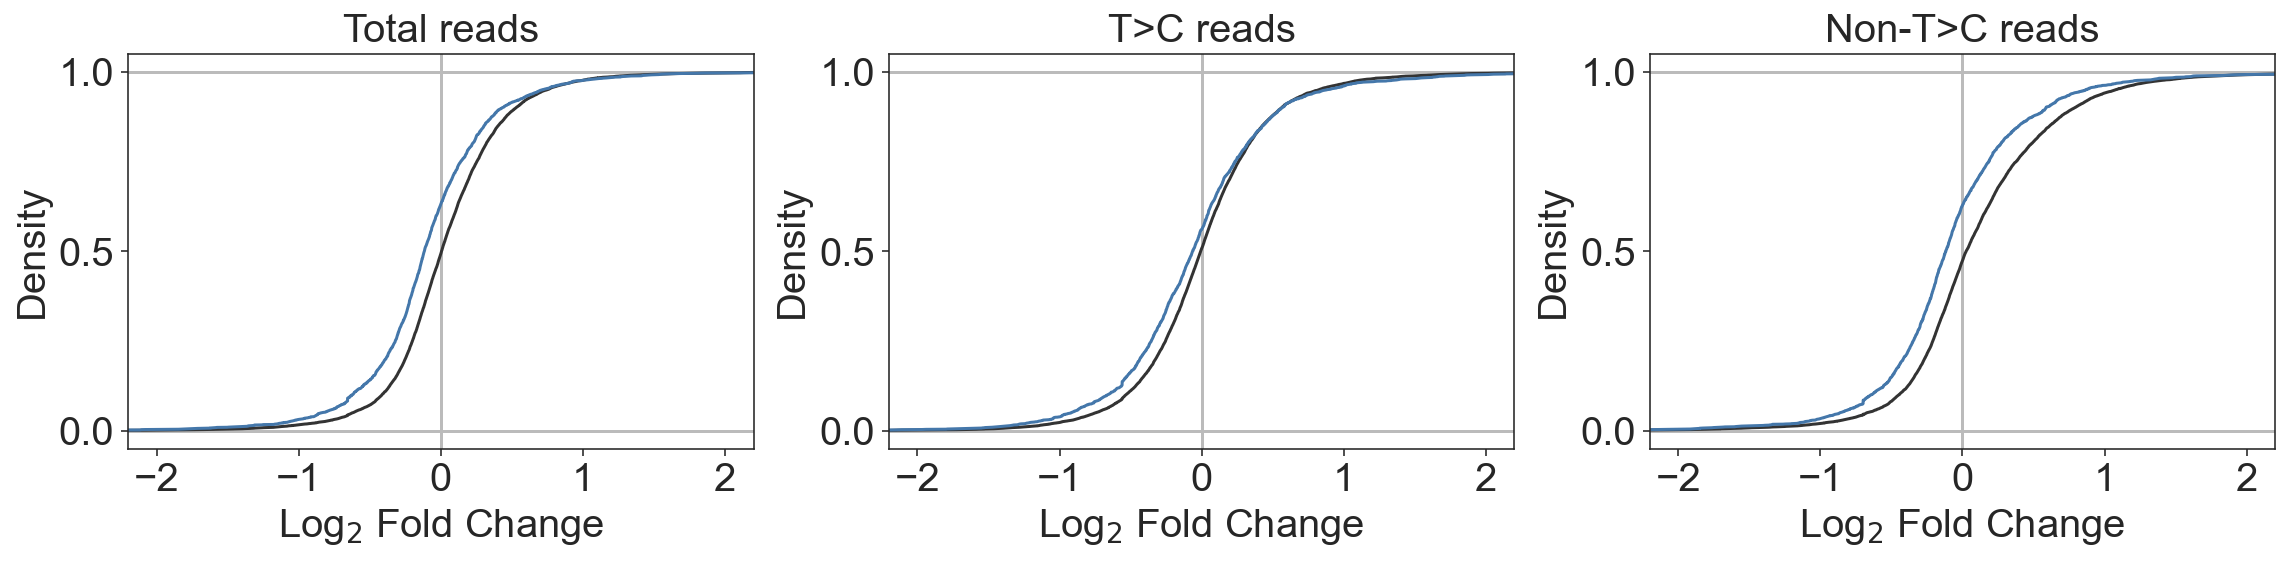

In [12]:
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data2 = df[df["localization"] == 1]["log2FC"]     # ER localized genes
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data2), 1 * np.arange(len(data2)) / (len(data2) - 1), color=blue, label="ER surface")
    
    # Mann-Whitney U test
    KstestResult1 = stats.kstest(data1, "norm")
    KstestResult2 = stats.kstest(data2, "norm")
    MannResult_ER = stats.mannwhitneyu(data1, data2, alternative="two-sided")

    print(f"WMW test (ER): {MannResult_ER.pvalue}")
    
ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_ER_RNA.pdf", bbox_inches="tight", transparent=True)

In [13]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["localization"] = df1.apply(is_targeted_ER, axis=1)
df2["localization"] = df2.apply(is_targeted_ER, axis=1)
df3["localization"] = df3.apply(is_targeted_ER, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (ER): 1.8436415910468965e-36
WMW test (ER): 5.7242673310001336e-06
WMW test (ER): 3.6264503010961796e-50


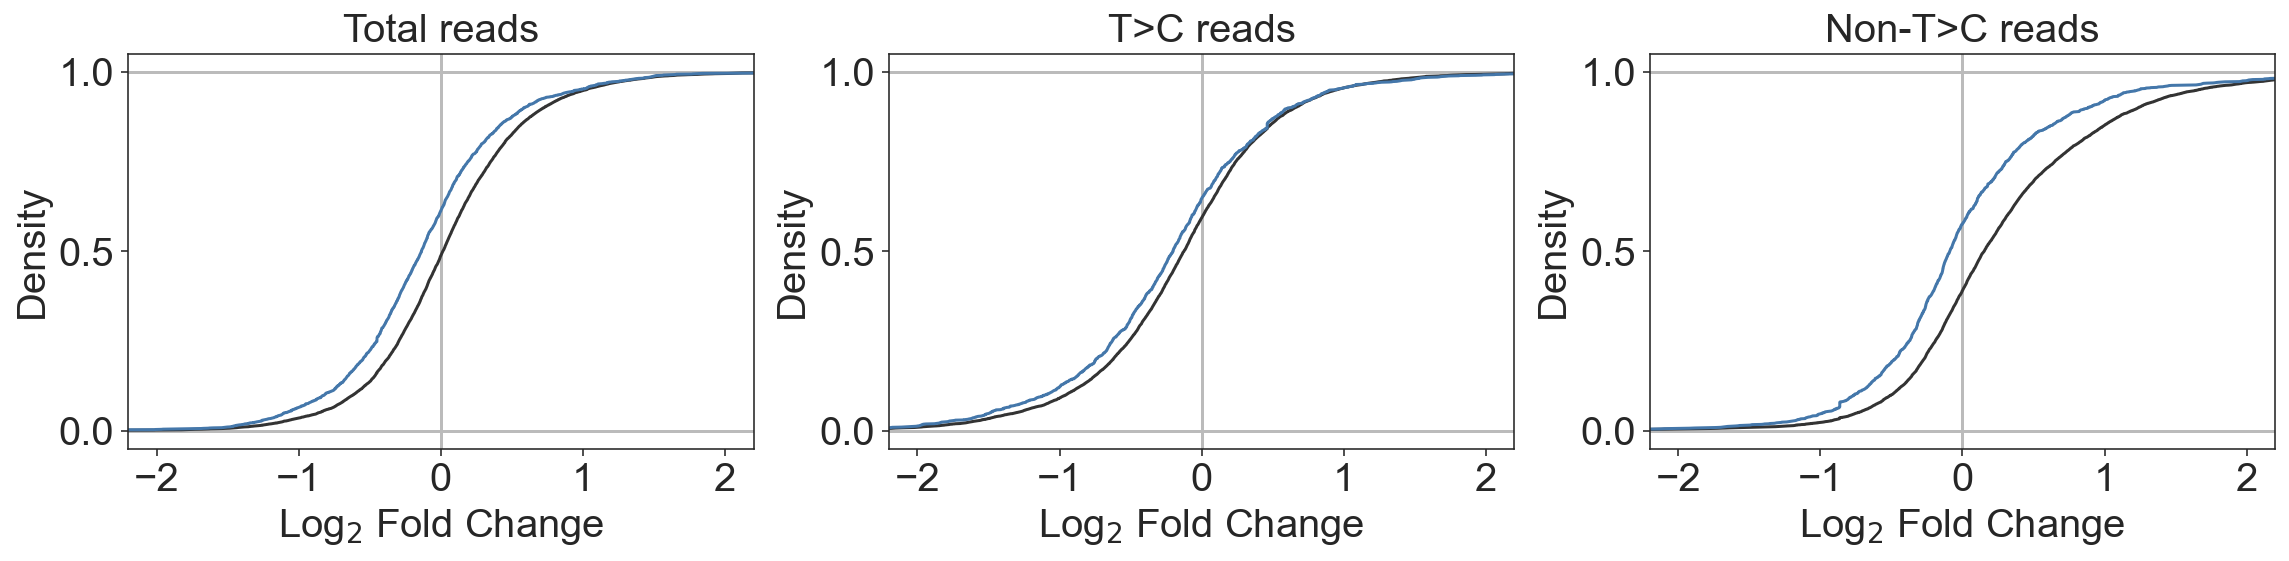

In [14]:
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data2 = df[df["localization"] == 1]["log2FC"]     # ER localized genes
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data2), 1 * np.arange(len(data2)) / (len(data2) - 1), color=blue, label="ER surface")
    
    # Mann-Whitney U test
    KstestResult1 = stats.kstest(data1, "norm")
    KstestResult2 = stats.kstest(data2, "norm")
    MannResult_ER = stats.mannwhitneyu(data1, data2, alternative="two-sided")

    print(f"WMW test (ER): {MannResult_ER.pvalue}")
    
ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_ER_P0.pdf", bbox_inches="tight", transparent=True)

In [15]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["localization"] = df1.apply(is_targeted_ER, axis=1)
df2["localization"] = df2.apply(is_targeted_ER, axis=1)
df3["localization"] = df3.apply(is_targeted_ER, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (ER): 7.415510261980667e-52
WMW test (ER): 3.1225978150042735e-12
WMW test (ER): 7.015259655594647e-56


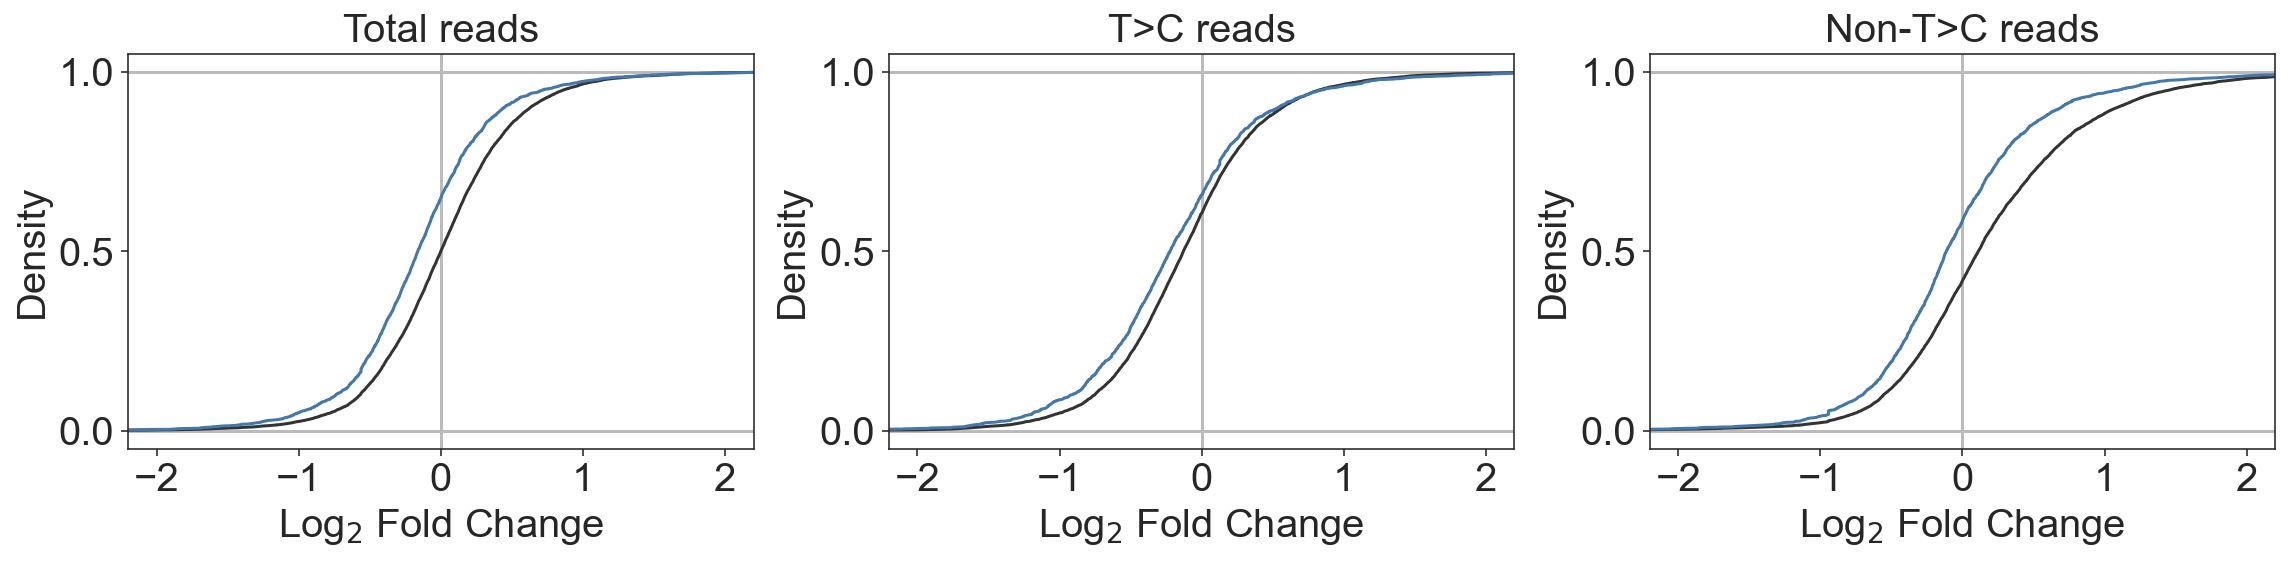

In [16]:
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data2 = df[df["localization"] == 1]["log2FC"]     # ER localized genes
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data2), 1 * np.arange(len(data2)) / (len(data2) - 1), color=blue, label="ER surface")
    
    # Mann-Whitney U test
    KstestResult1 = stats.kstest(data1, "norm")
    KstestResult2 = stats.kstest(data2, "norm")
    MannResult_ER = stats.mannwhitneyu(data1, data2, alternative="two-sided")

    print(f"WMW test (ER): {MannResult_ER.pvalue}")
    
ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_ER_L10a.pdf", bbox_inches="tight", transparent=True)

# ATF4/CHOP/XBP1/ATF6 targets

In [17]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/Total_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["ATF4_CHOP"] = df1.apply(is_ATF4_and_CHOP_target, axis=1)
df1["XBP1_ATF6"] = df1.apply(is_XBP1_and_ATF6_target, axis=1)
df2["ATF4_CHOP"] = df2.apply(is_ATF4_and_CHOP_target, axis=1)
df2["XBP1_ATF6"] = df2.apply(is_XBP1_and_ATF6_target, axis=1)
df3["ATF4_CHOP"] = df3.apply(is_ATF4_and_CHOP_target, axis=1)
df3["XBP1_ATF6"] = df3.apply(is_XBP1_and_ATF6_target, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (ATF4, CHOP): 0.0004401945904473867
WMW test (XBP1, ATF6): 9.79541676511293e-15
WMW test (ATF4, CHOP): 4.115217359061408e-06
WMW test (XBP1, ATF6): 1.051726003572735e-44
WMW test (ATF4, CHOP): 0.10215900581288673
WMW test (XBP1, ATF6): 0.42029173605169934


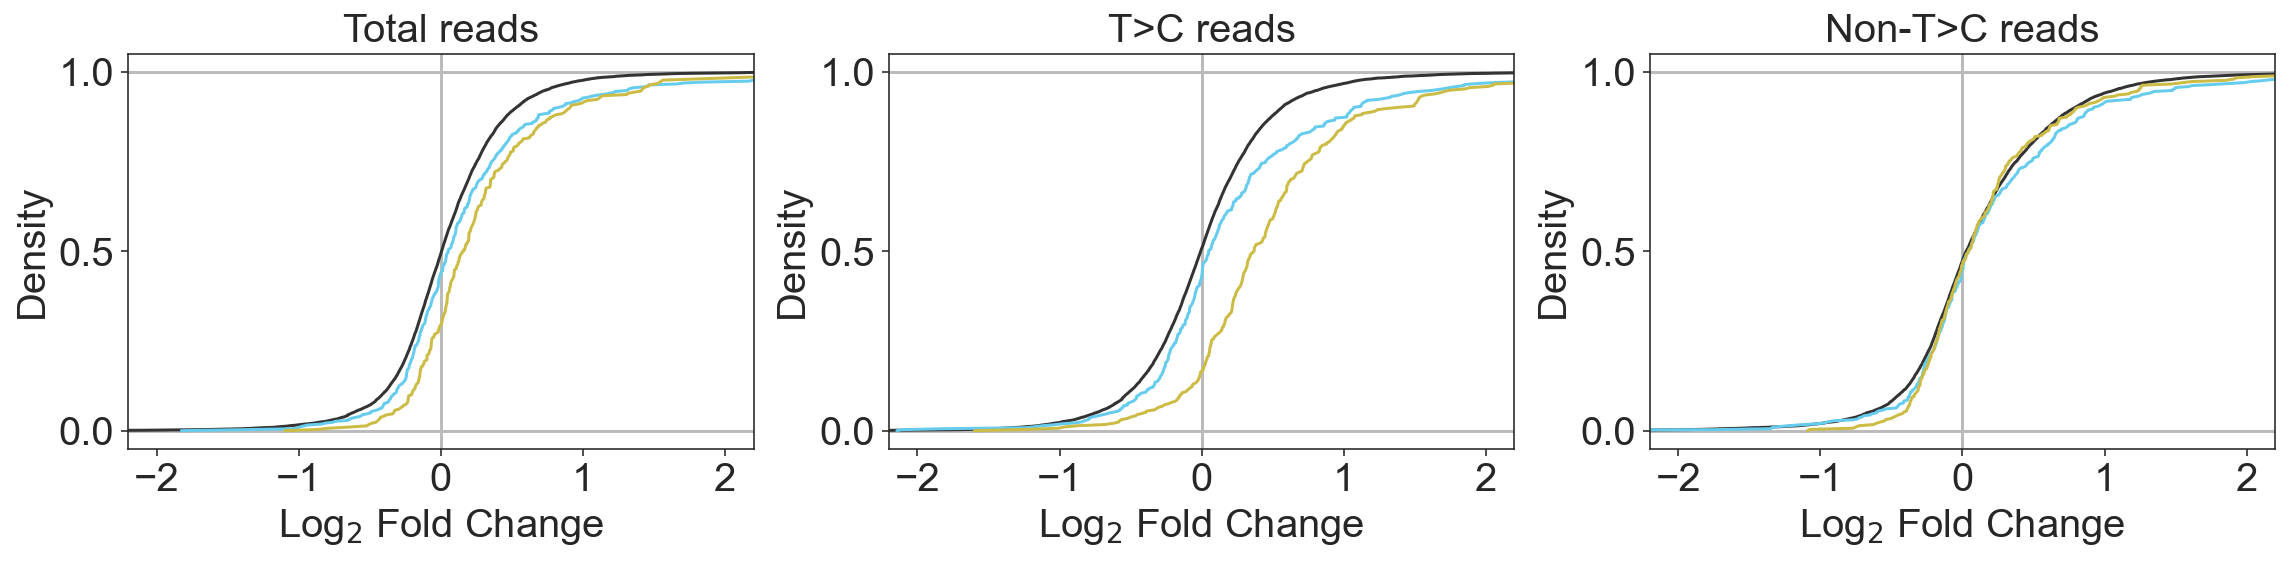

In [18]:
# subplot
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data4 = df[df["ATF4_CHOP"] == 1]["log2FC"]   # Target of ATF4 and CHOP
    data5 = df[df["XBP1_ATF6"] == 1]["log2FC"]   # Target of XBP1 and ATF6
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data4), 1 * np.arange(len(data4)) / (len(data4) - 1), color=cyan, label="ATF4 and CHOP")
    ax.plot(np.sort(data5), 1 * np.arange(len(data5)) / (len(data5) - 1), color=yellow, label="XBP1s and ATF6")
    
    # Mann-Whitney U test
    MannResult_ATF4CHOP = stats.mannwhitneyu(data1, data4, alternative="two-sided")
    MannResult_XBP1ATF6 = stats.mannwhitneyu(data1, data5, alternative="two-sided")
    print(f"WMW test (ATF4, CHOP): {MannResult_ATF4CHOP.pvalue}")
    print(f"WMW test (XBP1, ATF6): {MannResult_XBP1ATF6.pvalue}")
    
ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_TFs_RNA.pdf", bbox_inches="tight", transparent=True)

In [19]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/P-TRAP_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["ATF4_CHOP"] = df1.apply(is_ATF4_and_CHOP_target, axis=1)
df1["XBP1_ATF6"] = df1.apply(is_XBP1_and_ATF6_target, axis=1)
df2["ATF4_CHOP"] = df2.apply(is_ATF4_and_CHOP_target, axis=1)
df2["XBP1_ATF6"] = df2.apply(is_XBP1_and_ATF6_target, axis=1)
df3["ATF4_CHOP"] = df3.apply(is_ATF4_and_CHOP_target, axis=1)
df3["XBP1_ATF6"] = df3.apply(is_XBP1_and_ATF6_target, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (ATF4, CHOP): 0.0037457863574531644
WMW test (XBP1, ATF6): 8.25742637323111e-06
WMW test (ATF4, CHOP): 0.003074550487790482
WMW test (XBP1, ATF6): 9.106603275329875e-18
WMW test (ATF4, CHOP): 0.01657712099704422
WMW test (XBP1, ATF6): 0.9124739712890313


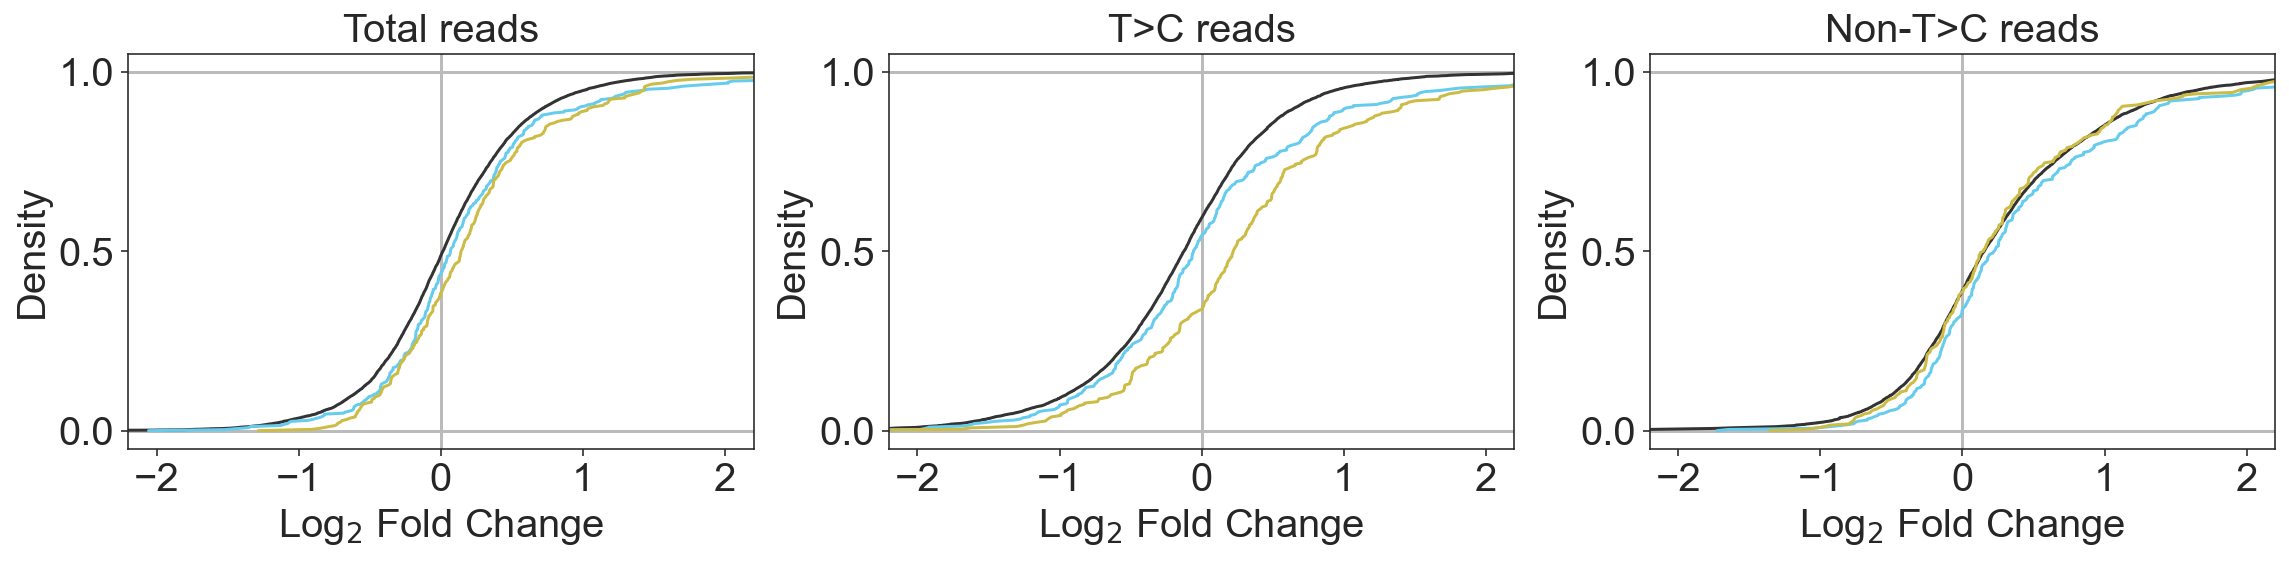

In [20]:
# subplot
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                               # Background (total genes)
    data4 = df[df["ATF4_CHOP"] == 1]["log2FC"]   # Target of ATF4 and CHOP
    data5 = df[df["XBP1_ATF6"] == 1]["log2FC"]   # Target of XBP1 and ATF6
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data4), 1 * np.arange(len(data4)) / (len(data4) - 1), color=cyan, label="ATF4 and CHOP")
    ax.plot(np.sort(data5), 1 * np.arange(len(data5)) / (len(data5) - 1), color=yellow, label="XBP1s and ATF6")
    
    # Mann-Whitney U test
    MannResult_ATF4CHOP = stats.mannwhitneyu(data1, data4, alternative="two-sided")
    MannResult_XBP1ATF6 = stats.mannwhitneyu(data1, data5, alternative="two-sided")
    print(f"WMW test (ATF4, CHOP): {MannResult_ATF4CHOP.pvalue}")
    print(f"WMW test (XBP1, ATF6): {MannResult_XBP1ATF6.pvalue}")
    
ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_TFs_P0.pdf", bbox_inches="tight", transparent=True)

In [21]:
df1 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_All_DESeq2.txt", sep="\t", index_col="rownames(readCount)")
df2 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_TC_DESeq2.txt", sep="\t", index_col="rownames(tcReadCount)")
df3 = pd.read_csv("../rscript/deseq2_v2/result/L10a-TRAP_DMSOvsTPG_nonTC_DESeq2.txt", sep="\t", index_col="rownames(nonTcReadCount)")

df1["index"]  = df1.index
df2["index"]  = df2.index
df3["index"]  = df3.index

df1["gene"] = df1.apply(get_gene_name, axis=1)
df2["gene"] = df2.apply(get_gene_name, axis=1)
df3["gene"] = df3.apply(get_gene_name, axis=1)

df1["ATF4_CHOP"] = df1.apply(is_ATF4_and_CHOP_target, axis=1)
df1["XBP1_ATF6"] = df1.apply(is_XBP1_and_ATF6_target, axis=1)
df2["ATF4_CHOP"] = df2.apply(is_ATF4_and_CHOP_target, axis=1)
df2["XBP1_ATF6"] = df2.apply(is_XBP1_and_ATF6_target, axis=1)
df3["ATF4_CHOP"] = df3.apply(is_ATF4_and_CHOP_target, axis=1)
df3["XBP1_ATF6"] = df3.apply(is_XBP1_and_ATF6_target, axis=1)

# Count zero
df1["zero"] = df1.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df2["zero"] = df2.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df3["zero"] = df3.iloc[:, 0:6].apply(lambda s: (s == 0).sum(), axis=1)
df1 = df1[df1["zero"] == 0]
df2 = df2[df2["zero"] == 0]
df3 = df3[df3["zero"] == 0]

WMW test (ATF4, CHOP): 1.3597486644386561e-06
WMW test (XBP1, ATF6): 1.9247199394797456e-12
WMW test (ATF4, CHOP): 3.1161834275475865e-08
WMW test (XBP1, ATF6): 1.7622304584918825e-33
WMW test (ATF4, CHOP): 0.00201535295259752
WMW test (XBP1, ATF6): 0.2767650224182574


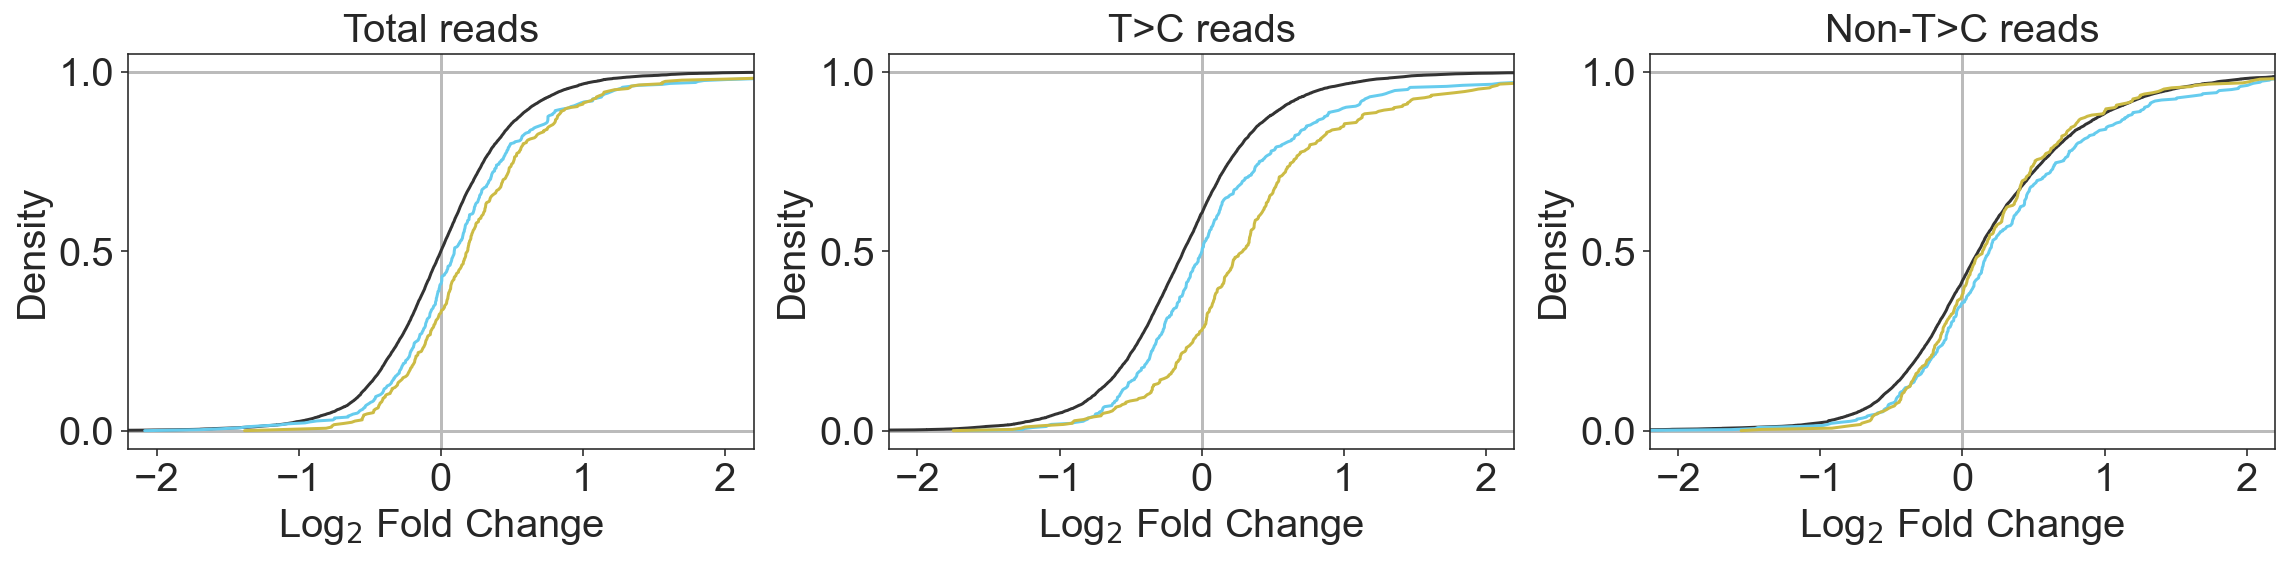

In [22]:
# subplot
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for df, ax in zip((df1, df2, df3), (ax1, ax2, ax3)):
    ax.axhline(0, -40, 40, color=grey, linewidth=1.5)
    ax.axhline(1, -40, 40, color=grey, linewidth=1.5)
    ax.axvline(0, -40, 40, color=grey, linewidth=1.5)
    
    ax.set_xlim(-2.2, 2.2)
    ax.tick_params(direction="out", labelsize=20)
    ax.set_xlabel("Log" + "$_{2}$" + " Fold Change", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    
    # select data
    data1 = df["log2FC"].dropna()                                                # Background (total genes)
    data4 = df[df["ATF4_CHOP"] == 1]["log2FC"].dropna()    # Target of ATF4 and CHOP
    data5 = df[df["XBP1_ATF6"] == 1]["log2FC"].dropna()    # Target of XBP1 and ATF6
    
    # plot
    ax.plot(np.sort(data1), 1 * np.arange(len(data1)) / (len(data1) - 1), color=black, label="All genes")
    ax.plot(np.sort(data4), 1 * np.arange(len(data4)) / (len(data4) - 1), color=cyan, label="ATF4 and CHOP")
    ax.plot(np.sort(data5), 1 * np.arange(len(data5)) / (len(data5) - 1), color=yellow, label="XBP1s and ATF6")
    
    # Mann-Whitney U test
    MannResult_ATF4CHOP = stats.mannwhitneyu(data1, data4, alternative="two-sided")
    MannResult_XBP1ATF6 = stats.mannwhitneyu(data1, data5, alternative="two-sided")
    print(f"WMW test (ATF4, CHOP): {MannResult_ATF4CHOP.pvalue}")
    print(f"WMW test (XBP1, ATF6): {MannResult_XBP1ATF6.pvalue}")
    
ax1.set_title("Total reads", size=20)
ax2.set_title("T>C reads", size=20)
ax3.set_title("Non-T>C reads", size=20)

fig.savefig("../results/figure_6/Densityplot_TFs_L10a.pdf", bbox_inches="tight", transparent=True)